In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tire
from scipy.optimize import newton

In [2]:
# Weights of parts of the car in lbs
W_uf = 25  #Front unsprung weight (lb)
W_ur = 25  #Rear unsprung weight (lb)
W_s  = 550 #Sprung weight (lb)
# CG locations
z_wf = 0.7  #Front unsprung height (ft)
z_wr = 0.7  #Rear unsprung height (ft)
h_s  = 0.75 #Sprung height (ft)
a_s  = 2.5  #Sprung distance from front axle (ft)
# Car geometry
l   = 5 #Wheelbase (ft)
t_f = 4 #Front track (ft)
t_r = 4 #Rear track (ft)
# Roll center heights
z_rf = 0.125 #Front roll center height
z_rr = 0.25  #Rear roll center height
# Roll rates
K_f = 17.5e3 #Front roll rate (lb-ft/rad)
K_r = 17.5e3 #Rear roll rate (lb-ft/rad)
# Steering
ack = 0.5 #Steering Ackerman (%)
toe_f = -0.5 #Front toe (deg)
toe_r = 0.5 #Rear toe (deg)
# Calculated values
theta = np.arctan((z_rr-z_rf)/l) #Inclination of roll axis (rad)
h_2 = (h_s - a_s*(z_rr-z_rf)/l - z_rf)*np.cos(theta) #Distance between sprung CG and roll axis
print('theta: %0.2f deg' % (theta*180/np.pi))
print('h_2  : %0.2f in' % (h_2*12))

theta: 1.43 deg
h_2  : 6.75 in


In [3]:
# Calculate the roll sensitivity and weight transfer
phi = -W_s*h_2 / (K_f+K_r-W_s*h_2)
K_fp = K_f - (l-a_s)*W_s*h_2/l
DW_f = (-phi*K_fp + W_s*(l-a_s)*z_rf/l+W_uf*z_wf)/t_f
K_rp = K_r - a_s*W_s*h_2/l
DW_r = (-phi*K_rp + W_s*a_s*z_rr/l+W_ur*z_wr)/t_r
print('Roll sensitivity: %0.2f deg/g' % (phi*180/np.pi))
print('Front weight transfer: %0.2f lb/g' % DW_f)
print('Rear weight transfer:  %0.2f lb/g' % DW_r)

Roll sensitivity: -0.51 deg/g
Front weight transfer: 51.63 lb/g
Rear weight transfer:  60.22 lb/g


In [4]:
# Front to rear weight transfer
DW_x = (h_s*W_s+z_wf*W_uf+z_wr*W_ur)/l
DW_y = (h_s*W_s+z_wf*W_uf+z_wr*W_ur)/t_f
print('Longitudinal weight transfer: %0.2f lb/g' % DW_x)
print('Lateral weight transfer: %0.2f lb/g' % DW_y)

Longitudinal weight transfer: 89.50 lb/g
Lateral weight transfer: 111.88 lb/g


In [5]:
# From these we can write the wheel loads as a function of acceleration
# Positive lateral acceleration adds weight to the left
# Positive longitudinal acceleration adds weight to the rear
W_f0 = (W_uf + W_s*(l-a_s)/l)/2
W_r0 = (W_ur + W_s*a_s/l)/2
def load_from_A(A):
    """ Calculate the wheel loads as a function of acceleration in g's. """
    W_fr = W_f0 - A[0]*DW_x - A[1]*DW_f
    W_fl = W_f0 - A[0]*DW_x + A[1]*DW_f
    W_rr = W_r0 + A[0]*DW_x - A[1]*DW_r
    W_rl = W_r0 + A[0]*DW_x + A[1]*DW_r
    return W_fr, W_fl, W_rr, W_rl

In [6]:
# For a given steer angle and side slip angle, what are the slip angles
def slip_from_steer(delta, beta, r):
    """ Calculate the slip angles as a function of steer and thrust angle in rad. """
    delta_i = 180*np.arctan(l/(l/np.tan(abs(delta)*np.pi/180)-t_f/2))/np.pi
    delta_o = 180*np.arctan(l/(l/np.tan(abs(delta)*np.pi/180)+t_f/2))/np.pi
    delta_i = ack*(delta_i - delta) + delta
    delta_o = ack*(delta_o - delta) + delta
    xi_f = 180*np.arctan(a_s/r)/np.pi
    xi_r = 180*np.arctan((l-a_s)/r)/np.pi
    if delta >= 0:
        delta_r = delta_i
        delta_l = delta_o
    else:
        delta_r = -delta_o
        delta_l = -delta_i
        xi_f *= -1
        xi_r *= -1
    a_fr = beta+toe_f-delta_r+xi_f
    a_fl = beta-toe_f-delta_l+xi_f
    a_rr = beta+toe_r-xi_r
    a_rl = beta-toe_r-xi_r
    return a_fr, a_fl, a_rr, a_rl

In [7]:
v = 45  #Speed (mph)
r = 100 #Turn radius (ft)
delta = 1.7
beta = -4.32
t = tire.Hoosier10X7()
A_y = 0.06689*v**2/r
print('Lateral Acceleration:', A_y)
print('Necessary front tire force:', A_y*(W_s+W_uf+W_ur)*a_s/l)
print('Necessary rear tire force:', A_y*(W_s+W_uf+W_ur)*(l-a_s)/l)
load = load_from_A((0, A_y))
SA = slip_from_steer(delta, beta, r)
F_fr = t.get_force(-load[0]*4.448, SA[0], 0, 0)[1]*0.225
F_fl = t.get_force(-load[1]*4.448, SA[1], 0, 0)[1]*0.225
F_rr = t.get_force(-load[2]*4.448, SA[2], 0, 0)[1]*0.225
F_rl = t.get_force(-load[3]*4.448, SA[3], 0, 0)[1]*0.225
print('Total front tire force:', F_fr*np.cos(SA[0]*np.pi/180)+F_fl*np.cos(SA[1]*np.pi/180))
print('Total rear tire force:', F_rr*np.cos(SA[2]*np.pi/180)+F_rl*np.cos(SA[3]*np.pi/180))
print(F_fr*np.cos(SA[0]*np.pi/180), F_fl*np.cos(SA[1]*np.pi/180),
      F_rr*np.cos(SA[2]*np.pi/180), F_rl*np.cos(SA[3]*np.pi/180))

Lateral Acceleration: 1.3545225000000003
Necessary front tire force: 406.3567500000001
Necessary rear tire force: 406.3567500000001
Total front tire force: 379.035860415
Total rear tire force: 426.167807848
141.129680224 237.906180191 123.94725889 302.220548958


In [8]:
# Now calulate the steer angle and side slip angle for a given corner and velocity
def front_lateral_force(load, SA):
    F_fr = t.get_force(-load[0]*4.448, SA[0], 0, 0)[1]*0.225
    F_fl = t.get_force(-load[1]*4.448, SA[1], 0, 0)[1]*0.225
    F_fr *= np.cos(SA[0]*np.pi/180)
    F_fl *= np.cos(SA[1]*np.pi/180)
    return F_fr + F_fl
def rear_lateral_force(load, SA):
    F_rr = t.get_force(-load[2]*4.448, SA[2], 0, 0)[1]*0.225
    F_rl = t.get_force(-load[3]*4.448, SA[3], 0, 0)[1]*0.225
    F_rr *= np.cos(SA[2]*np.pi/180)
    F_rl *= np.cos(SA[3]*np.pi/180)
    return F_rr + F_rl
# First calculate the side slip angle for the rear tires
def rear_force(beta, A_y, r):
    load = load_from_A((0, A_y))
    delta = 0
    SA = slip_from_steer(delta, beta, r)
    return rear_lateral_force(load, SA) - A_y*(W_s+W_uf+W_ur)*(l-a_s)/l
def front_force(delta, A_y, beta, r):
    load = load_from_A((0, A_y))
    SA = slip_from_steer(delta, beta, r)
    return front_lateral_force(load, SA) - A_y*(W_s+W_uf+W_ur)*a_s/l
def get_steer_angle(v, r):
    """ Calculate the steer angle for a given speed and corner radius. """
    # v (mph), r(ft)
    A_y = 0.06689*v**2/r
    try:
        beta = newton(rear_force, 1, args=(A_y, r))
    except RuntimeError:
        beta = float('nan')
    try:
        delta = newton(front_force, 150/r, args=(A_y, beta, r))
    except RuntimeError:
        delta = float('nan')
    return beta, delta
v = 24.1  #Speed (mph)
r = 25 #Turn radius (ft)
beta, delta = get_steer_angle(v, r)
A_y = 0.06689*v**2/r
print(A_y, beta, delta)

1.5540152360000001 -5.69778555242 9.83635266483


/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


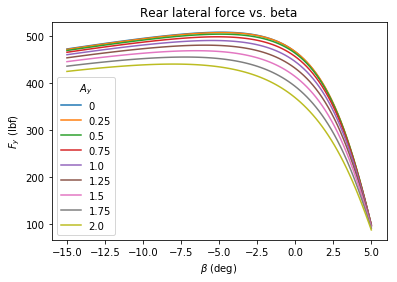

[ 150.          134.94442607  119.88885215  104.83327822   89.7777043
   74.72213037   59.66655645   44.61098252   29.5554086 ]
[ 150.          165.05557393  180.11114785  195.16672178  210.2222957
  225.27786963  240.33344355  255.38901748  270.4445914 ]


In [9]:
# Something isn't quite right, first look at rear lateral force as a function of beta
N = 100
M = 9
r = 25
beta = np.linspace(-15, 5, N)
A_y = np.linspace(0, 2, M)
force = np.zeros((M, N), dtype='double')
load_rr = np.zeros((M, N), dtype='double')
load_rl = np.zeros((M, N), dtype='double')
SA_rr = np.zeros((M, N), dtype='double')
SA_rl = np.zeros((M, N), dtype='double')
delta = 0
for i in range(M):
    for j in range(N):
        load = load_from_A((0, A_y[i]))
        load_rr[i, j] = load[2]
        load_rl[i, j] = load[3]
        SA = slip_from_steer(delta, beta[j], r)
        SA_rr[i, j] = SA[2]
        SA_rl[i, j] = SA[3]
        force[i, j] = rear_lateral_force(load, SA)
    plt.plot(beta, force[i ,:])
plt.legend([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0], title=r'$A_y$')
plt.title('Rear lateral force vs. beta')
plt.xlabel(r'$\beta$ (deg)')
plt.ylabel(r'$F_y$ (lbf)')
plt.show()
print(load_rr[:, 0])
print(load_rl[:, 0])
# The zero acceleration case has 0 load transfer and should definitely pass through the origin
# not necessarily true from 

/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


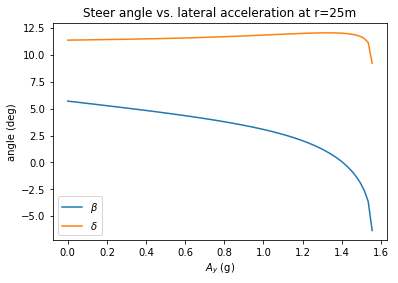

In [10]:
N = 100
r = 25
A_y = np.linspace(0, 2, N)
v = np.sqrt(A_y*r/0.06689)
beta = np.zeros(N, dtype='double')
delta = np.zeros(N, dtype='double')
for i in range(N):
    beta[i], delta[i] = get_steer_angle(v[i], r)
plt.plot(A_y, beta)
plt.plot(A_y, delta)
plt.title('Steer angle vs. lateral acceleration at r=25m')
plt.legend([r'$\beta$', r'$\delta$'])
plt.xlabel(r'$A_y$ (g)')
plt.ylabel(r'angle (deg)')
plt.show()

In [11]:
import car
import importlib
importlib.reload(car)

params = {
    'W_uf' : 111,    #Front unsprung weight (N)
    'W_ur' : 111,    #Rear unsprung weight  (N)
    'W_s'  : 2446,   #Sprung weight         (N)
    # CG locations
    'z_wf' : 0.21,   #Front unsprung height (m)
    'z_wr' : 0.21,   #Rear unsprung height  (m)
    'h_s'  : 0.23,   #Sprung height         (m)
    'a_s'  : 0.76,   #Sprung distance from front axle (m)
    # Car geometry
    'l'    : 1.524,  #Wheelbase   (m)
    't_f'  : 1.22,   #Front track (m)
    't_r'  : 1.22,   #Rear track  (m)
    # Roll center heights
    'z_rf' : 0.038,  #Front roll center height (m)
    'z_rr' : 0.076,  #Rear roll center height  (m)
    # Roll rates
    'K_f'  : 24.5e3, #Front roll rate (N-m/rad)
    'K_r'  : 24.5e3, #Rear roll rate  (N-m/rad)
    # Steering
    'ack'  : 0.5,    #Steering Ackerman (%)
    'toe_f': -0.5,   #Front toe (deg)
    'toe_r': 1.0,    #Rear toe  (deg)
    'tire' : tire.Hoosier10X7()
}
C = car.Car(params)
r = 8
A_y = 1.5
load = C.load_from_A(0.0, A_y)
print('Wheel loads:          %0.2f, %0.2f, %0.2f, %0.2f' % load)
SAp = C.calc_peak_slip_angles(load)
print('Optimal slip angles:  %0.2f, %0.2f, %0.2f, %0.2f' % SAp)
beta = 0 * (np.pi/180)
delta = 11 * (np.pi/180)
KA = C.kinematic_slip(beta, delta)
print('Kinematic slip:       %0.2f, %0.2f, %0.2f, %0.2f' % 
      (KA[0]*180/np.pi, KA[1]*180/np.pi, KA[2]*180/np.pi, KA[3]*180/np.pi))
RSA = C.radius_induced_slip(beta, r)
print('Radius ind slip:      %0.2f, %0.2f, %0.2f, %0.2f' % 
      (RSA[0]*180/np.pi, RSA[1]*180/np.pi, RSA[2]*180/np.pi, RSA[3]*180/np.pi))
SA = C.get_slip_angles(beta, r, KA)
print('Slip angles:          %0.2f, %0.2f, %0.2f, %0.2f' % 
      (SA[0]*180/np.pi, SA[1]*180/np.pi, SA[2]*180/np.pi, SA[3]*180/np.pi))
F = C.get_tire_forces(350, load, SA)
print('Tire lateral forces:  %0.2f, %0.2f, %0.2f, %0.2f' % (F[0][1], F[1][1], F[2][1], F[3][1]))
FE = C.get_effective_tire_forces(F, KA)
print('Eff long forces:      %0.2f, %0.2f, %0.2f, %0.2f' % (FE[0][0], FE[1][0], FE[2][0], FE[3][0]))
print('Eff lateral forces:   %0.2f, %0.2f, %0.2f, %0.2f' % (FE[0][1], FE[1][1], FE[2][1], FE[3][1]))

Roll axis inclination: 1.43 deg
Unsprung CG height from roll axis: 0.17 m
Roll sensitivity: -0.50 deg/g
Front longitudinal weight transfer: 230.72 N/g
Rear longitudinal weight transfer:  268.52 N/g
Longitudinal weight transfer:       399.74 N/g
Front static wheel load:            -668.60 N
Rear static wheel load:             -665.40 N
Total weight:     -2668.00 N
Wheel loads:          -322.53, -1014.68, -262.62, -1068.17
Optimal slip angles:  6.97, 12.54, 6.61, 13.10
Kinematic slip:       -11.95, -10.11, 1.00, -1.00
Radius ind slip:      5.87, 5.04, -5.90, -5.07
Slip angles:          -6.08, -5.07, -4.90, -6.07
Tire lateral forces:  595.26, 1215.03, 473.56, 1346.54
Eff long forces:      -123.27, -213.32, 183.24, 151.47
Eff lateral forces:   582.36, 1196.15, 470.44, 1349.39


In [12]:
# Now lets see if I can solve for a steady state cornering condition
# I think iteratively calculate A_y and loads
r = 8
# Test converging on lateral acceleration
beta = 1
delta = 10
beta *= (np.pi/180)
delta *= (np.pi/180)
A_y = 0.5
Fx = 200
for k in range(100):
    load = C.load_from_A(-A_y*np.sin(beta), A_y*np.cos(beta))
    KA = C.kinematic_slip(beta, delta)
    SA = C.get_slip_angles(beta, r, KA)
    F = C.get_tire_forces(Fx, load, SA)
    FE = C.get_effective_tire_forces(F, KA)
    Fx += -C.calc_total_longitudinal_force(FE)
    A_y = -C.calc_total_lateral_force(FE)/C.W
print(A_y)
print('Slip angles:          %0.2f, %0.2f, %0.2f, %0.2f' % 
      (SA[0]*180/np.pi, SA[1]*180/np.pi, SA[2]*180/np.pi, SA[3]*180/np.pi))
print('Eff long forces:      %0.2f, %0.2f, %0.2f, %0.2f' % (FE[0][0], FE[1][0], FE[2][0], FE[3][0]))
print('Eff lateral forces:   %0.2f, %0.2f, %0.2f, %0.2f' % (FE[0][1], FE[1][1], FE[2][1], FE[3][1]))

1.22282374493
Slip angles:          -3.93, -3.21, -3.83, -5.15
Eff long forces:      -108.68, -127.38, 127.43, 108.63
Eff lateral forces:   624.58, 886.53, 536.59, 1214.79


In [13]:
# Lets try using a root finding algorithm to find this for a given beta
r = 8
beta = 0.0
delta0 = 12
beta *= (np.pi/180)
delta0 *= (np.pi/180)
def Mx_from_delta(delta, r, beta):
    Ay, Fx, load, KA, SA, F, FE = C.Ay_Fx_from_angle(r, beta, delta, extra=True)
    FC = C.get_chassis_tire_forces(F, KA, beta)
    Mz = C.calc_yaw_moment(FC)
    return Mz
delta = newton(Mx_from_delta, delta0, args=(r, beta))
print(delta*180/np.pi)

13.1140886678


In [14]:
def get_delta(r, beta):
    """ Calculate the steer angle for a given speed and corner radius. """
    try:
        delta = newton(Mx_from_delta, delta0, args=(r, beta))
    except RuntimeError:
        delta = float('nan')
    if abs(delta) > 0.5:
        delta = float('nan')
    return delta

In [15]:
N = 100
r = 4
beta = np.linspace(-5, 10, N)
delta0 = 15
beta *= (np.pi/180)
delta0 *= (np.pi/180)
delta = np.zeros(N, dtype='double')
Ay = np.zeros(N, dtype='double')
for i in range(N):
    delta[i] = get_delta(r, beta[i])
    Ay[i], Fx = C.Ay_Fx_from_angle(r, beta[i], delta[i])

/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


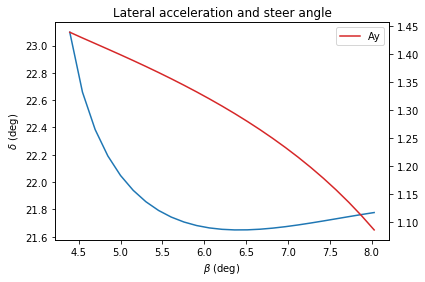

In [16]:
sel = Ay > 0
plt.plot(beta[sel]*180/np.pi, delta[sel]*180/np.pi, 'tab:blue')
plt.title('Lateral acceleration and steer angle')
plt.xlabel(r'$\beta$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.twinx()
plt.plot(beta[sel]*180/np.pi, Ay[sel], 'tab:red')
plt.legend([r'Ay'])
plt.show()